## Time-Series Recurrent Variational Autoencoder

Let's start by choosing some data. It's fun to use audio because we can listen to the results, so I'm going to load an Erik Satie piano piece.

In [1]:
import torch
import torchaudio
import torch.nn as nn

In [2]:
import matplotlib.pyplot as plt

In [3]:
from IPython.display import Audio

In [4]:
import os, requests

In [5]:
audio_files = [
    ('https://upload.wikimedia.org/wikipedia/commons/9/90/',
     'Erik_Satie_-_gymnopedies_-_la_1_ere._lent_et_douloureux.ogg'),
    ('https://upload.wikimedia.org/wikipedia/commons/9/91/',
     'Satie_-_Gnossienne_1.ogg')
]

In [6]:
if not os.path.exists('data'):
    os.makedirs('data')
    
waves = []
rates = []
for url, filename in audio_files:
    if not os.path.exists(f'data/{filename}'):
        print (f'data/{filename}')
        print (url + filename)
        
        response = requests.get(
            url + filename,
            headers={'User-Agent':"FetchingBot/1.0 (callistb@pdx.edu)"}
        )
        
        if response.status_code == 200:
            with open(f'data/{filename}', 'wb') as f:
                f.write(response.content)
              
    wave, rate = torchaudio.load(f'data/{filename}')
    
    # blend stero and normalize
    
    wave = wave.mean(0)
    wave -= wave.min()
    wave /= wave.max()
    
    waves.append(wave)
    rates.append(rate)

In [7]:
assert(all([rate==44100 for rate in rates]))
rate = 44100

In [8]:
# concatenate files
waves = torch.cat(waves)

### Audio transforms

In [9]:
# show a 5 second clip

In [10]:
clip = waves[rate * 5 : rate * 10]

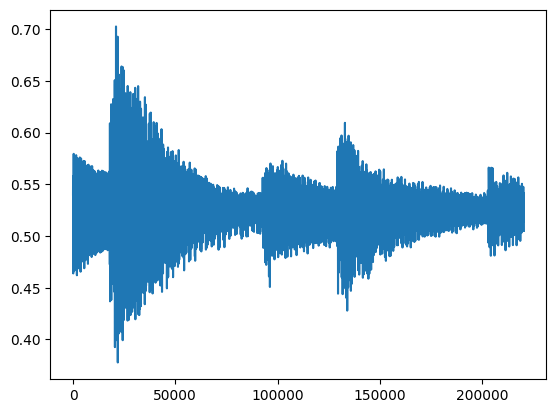

In [11]:
plt.plot(clip)

In [12]:
Audio(clip, rate=rate)

In [13]:
n_pca = 50

In [14]:
# sample 10000 1/10 second patches and do pca
samples = torch.stack(
    [ waves[start : start + rate//10] 
     for start in torch.randint(low=0,high=len(waves)-rate//10,size=[10000]) 
    ]
)

In [15]:
u,s,v = torch.pca_lowrank(samples, q=n_pca)

In [16]:
# extract overlapping 1/10 second patches from audio

In [17]:
patch_size = rate//10
stride     = patch_size//2
starts = range(0, len(waves)-patch_size, stride)

In [18]:
patches = torch.stack(
    [ waves[start : start + rate//10] 
     for start in starts
    ]
)

In [19]:
# transform to pca basis

In [20]:
patches_pca = torch.mm(patches, v)

In [21]:
patches_pca.shape

torch.Size([8030, 50])

In [22]:
pca_means = patches_pca.mean(0)

In [23]:
patches_pca /= pca_means

In [24]:
# do stuff

In [25]:
# transform back to audio basis

In [26]:
patches_reco = torch.mm(patches_pca * pca_means, v.T)

In [27]:
patches_reco.shape

torch.Size([8030, 4410])

In [28]:
# reassemble audio from patches
audio_reco = torch.zeros_like(waves)
for i, start in enumerate(starts):
    audio_reco[start:start+patch_size] += patches_reco[i]/2

In [29]:
audio_reco.max()

tensor(0.9363)

In [30]:
Audio(audio_reco[:1000000], rate=rate)

Reconstruction is lossy but still captures structure

### Dataset generation

Split up 

In [31]:
patches_pca.shape

torch.Size([8030, 50])

In [32]:
# size is n_patches * n_pca. each patch represents 1/10th of a second, with a stride of 1/20th of a second
# so a sequence of 20 patches would correspond to 1.0 second of audio

In [33]:
seq_len = 20
dataset = torch.stack([
    patches_pca[start:start+seq_len, :]
    for start in range(0, len(patches_pca) - seq_len, seq_len//2) # some overlap
])

In [34]:
# should be [n_batches, seq_len, n_pca]
dataset.shape

torch.Size([801, 20, 50])

In [35]:
perm = torch.randperm(len(dataset))

In [191]:
train_N = int(0.7 * len(dataset))
train_loader = torch.utils.data.DataLoader(dataset[perm][:train_N], batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset[perm][train_N:], batch_size=1)

In [192]:
# number of training batches and testing batches
len(iter(train_loader)), len(iter(test_loader))

(140, 241)

### Autoencoder Specification

In [193]:
class Decoder(nn.Module):
    
    def __init__(self, hidden_dim=128, output_dim=n_pca):
        super().__init__()
        self.hidden_dim=hidden_dim
        self.output_dim=output_dim
        
        self.gru = nn.GRU(input_size=output_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc  = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z_in, h_in):
        
        _, h_out = self.gru(z_in, h_in.transpose(0,1))
        x_out    = self.fc(h_out.transpose(0,1))
        
        return x_out, h_out.transpose(0,1)
        
        
class Encoder(nn.Module):
    def __init__(self, hidden_dim=128, input_dim=n_pca):
        super().__init__()
        
        self.fc    = nn.Linear(input_dim, hidden_dim)
        self.gru   = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        
    def forward(self, x_in):
        
        x_in = self.fc(x_in)
        _, h_out = self.gru(x_in)
        
        h_out = h_out.transpose(0,1)
        
        return h_out
    
class RAE(nn.Module):
    def __init__(self, hidden_dim=128, input_dim=n_pca, use_device='cuda:0'):
        super().__init__()
        self.encoder = Encoder(hidden_dim, input_dim)
        self.decoder = Decoder(hidden_dim, input_dim)
        
        self.hidden_dim=hidden_dim
        self.input_dim=input_dim
        
        self.to(use_device)
    
     
    def forward(self, x):
        batch_size, seq_len, n_dim = x.shape

        h_in = self.encoder(x)
        z_in = x.new_zeros([batch_size, 1, n_dim])
        
        out = []
        for _ in range(seq_len):
            x_out, h_out = self.decoder(z_in, h_in)
            z_in = x_out
            h_in = h_out
            out.append(x_out)
            
        return torch.cat(out, 1)            

In [194]:
device = 'cuda:3'

In [195]:
rae = RAE(use_device = device)
optimizer = torch.optim.Adagrad(params = rae.parameters(), lr=1e-2, weight_decay=1e-3)

In [196]:
rae

RAE(
  (encoder): Encoder(
    (fc): Linear(in_features=50, out_features=128, bias=True)
    (gru): GRU(128, 128, batch_first=True)
  )
  (decoder): Decoder(
    (gru): GRU(50, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [197]:
loss_fn = nn.L1Loss()

In [198]:
train_losses = []
test_losses  = []
for epoch in range(500):
    print(f'Epoch: {epoch}\n------------')
    
    epoch_train_loss = 0.0
    for x_batch in train_loader:
        
        x_batch = x_batch.to(device)
        x_reco = rae(x_batch)

        optimizer.zero_grad()
        
        loss = loss_fn(x_reco, x_batch)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    epoch_train_loss /= len(iter(train_loader))
    print(f"Avg train loss: {epoch_train_loss}")
    train_losses.append(epoch_train_loss)
        
    with torch.no_grad():
        epoch_test_loss = 0.0
        for x_batch in test_loader:
            
            x_batch = x_batch.to(device)
            x_reco  = rae(x_batch)
            
            loss = loss_fn(x_reco, x_batch)
            epoch_test_loss += loss.item()
        epoch_test_loss /= len(iter(test_loader))
        print(f"Avg test loss: {epoch_test_loss}")
        test_losses.append(epoch_test_loss)
            
            

Epoch: 0
------------
Avg train loss: 7.495618473631995
Avg test loss: 7.0558317416189125
Epoch: 1
------------
Avg train loss: 7.4792401926858085
Avg test loss: 7.045326331498959
Epoch: 2
------------
Avg train loss: 7.468694337776729
Avg test loss: 7.040660475979702
Epoch: 3
------------
Avg train loss: 7.45921630689076
Avg test loss: 7.019933130978549
Epoch: 4
------------
Avg train loss: 7.451451912948063
Avg test loss: 7.014246077272902
Epoch: 5
------------
Avg train loss: 7.443648157800947
Avg test loss: 7.007638691866546
Epoch: 6
------------
Avg train loss: 7.438238523687635
Avg test loss: 7.001441136311693
Epoch: 7
------------
Avg train loss: 7.433283029283796
Avg test loss: 6.9991609345642365
Epoch: 8
------------
Avg train loss: 7.427073718820299
Avg test loss: 6.995042093932876
Epoch: 9
------------
Avg train loss: 7.424180127893176
Avg test loss: 6.997628454845476
Epoch: 10
------------
Avg train loss: 7.424930315358298
Avg test loss: 6.996692892612264
Epoch: 11
--------

Avg train loss: 7.3460919993264335
Avg test loss: 6.937395735183939
Epoch: 92
------------
Avg train loss: 7.345692656721387
Avg test loss: 6.938829348851536
Epoch: 93
------------
Avg train loss: 7.3447732176099505
Avg test loss: 6.937072013207244
Epoch: 94
------------
Avg train loss: 7.345282132284982
Avg test loss: 6.9384355114703355
Epoch: 95
------------
Avg train loss: 7.34405849150249
Avg test loss: 6.936150634993656
Epoch: 96
------------
Avg train loss: 7.343619387490409
Avg test loss: 6.936621403576675
Epoch: 97
------------
Avg train loss: 7.342239345823016
Avg test loss: 6.938429253910092
Epoch: 98
------------
Avg train loss: 7.34222582578659
Avg test loss: 6.938981074175152
Epoch: 99
------------
Avg train loss: 7.341651199545179
Avg test loss: 6.938659540968811
Epoch: 100
------------
Avg train loss: 7.343305603095463
Avg test loss: 6.952450551803676
Epoch: 101
------------
Avg train loss: 7.342393248421805
Avg test loss: 6.935990123209617
Epoch: 102
------------
Avg tr

Avg test loss: 6.9288529275271165
Epoch: 182
------------
Avg train loss: 7.3100889921188354
Avg test loss: 6.926572314096437
Epoch: 183
------------
Avg train loss: 7.310197726317814
Avg test loss: 6.931360560766889
Epoch: 184
------------
Avg train loss: 7.310526393141065
Avg test loss: 6.92716787770947
Epoch: 185
------------
Avg train loss: 7.310349270275661
Avg test loss: 6.927651877704374
Epoch: 186
------------
Avg train loss: 7.310464678491865
Avg test loss: 6.928568787053536
Epoch: 187
------------
Avg train loss: 7.310224718706948
Avg test loss: 6.928569977940737
Epoch: 188
------------
Avg train loss: 7.310272589751652
Avg test loss: 6.930579104425997
Epoch: 189
------------
Avg train loss: 7.30895374417305
Avg test loss: 6.92838524377816
Epoch: 190
------------
Avg train loss: 7.309067005770547
Avg test loss: 6.930792287115734
Epoch: 191
------------
Avg train loss: 7.308191049098968
Avg test loss: 6.9276965886076205
Epoch: 192
------------
Avg train loss: 7.30759607723781


Avg test loss: 6.932392144506156
Epoch: 272
------------
Avg train loss: 7.274388745852879
Avg test loss: 6.932997024158224
Epoch: 273
------------
Avg train loss: 7.284727336679186
Avg test loss: 6.932679819893788
Epoch: 274
------------
Avg train loss: 7.279432594776154
Avg test loss: 6.934460304368334
Epoch: 275
------------
Avg train loss: 7.27405663728714
Avg test loss: 6.939572935838917
Epoch: 276
------------
Avg train loss: 7.272321644851139
Avg test loss: 6.9282267615817394
Epoch: 277
------------
Avg train loss: 7.272292472634997
Avg test loss: 6.932336858663074
Epoch: 278
------------
Avg train loss: 7.271010792255401
Avg test loss: 6.932317443037428
Epoch: 279
------------
Avg train loss: 7.270019587448665
Avg test loss: 6.93413228957423
Epoch: 280
------------
Avg train loss: 7.270140780721392
Avg test loss: 6.93648963854397
Epoch: 281
------------
Avg train loss: 7.268720071656364
Avg test loss: 6.936317770807575
Epoch: 282
------------
Avg train loss: 7.268708317620414
A

Avg test loss: 6.943140741824115
Epoch: 362
------------
Avg train loss: 7.221210895265852
Avg test loss: 6.941284123730857
Epoch: 363
------------
Avg train loss: 7.220637733595712
Avg test loss: 6.940867702032273
Epoch: 364
------------
Avg train loss: 7.2212856820651465
Avg test loss: 6.946413786146651
Epoch: 365
------------
Avg train loss: 7.219780961104802
Avg test loss: 6.946647066607515
Epoch: 366
------------
Avg train loss: 7.219510279382978
Avg test loss: 6.94362514598983
Epoch: 367
------------
Avg train loss: 7.21736889566694
Avg test loss: 6.944122603881903
Epoch: 368
------------
Avg train loss: 7.216991795812334
Avg test loss: 6.946432121005295
Epoch: 369
------------
Avg train loss: 7.219136445862906
Avg test loss: 6.944334962370485
Epoch: 370
------------
Avg train loss: 7.219665649959019
Avg test loss: 6.952869256811518
Epoch: 371
------------
Avg train loss: 7.2190406084060665
Avg test loss: 6.943279518626043
Epoch: 372
------------
Avg train loss: 7.215977229390826

Avg test loss: 6.9609038196658695
Epoch: 452
------------
Avg train loss: 7.182399896212987
Avg test loss: 6.960355473164453
Epoch: 453
------------
Avg train loss: 7.180318656989506
Avg test loss: 6.959539710362423
Epoch: 454
------------
Avg train loss: 7.180147865840367
Avg test loss: 6.9525925233280015
Epoch: 455
------------
Avg train loss: 7.179425607408796
Avg test loss: 6.956731425837857
Epoch: 456
------------
Avg train loss: 7.177342140674591
Avg test loss: 6.958961034000414
Epoch: 457
------------


KeyboardInterrupt: 

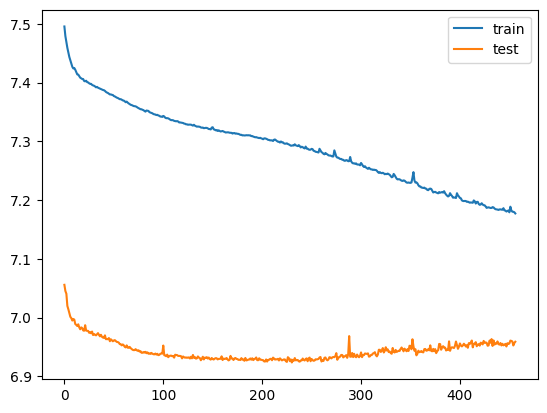

In [199]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

In [200]:
test_iter = iter(test_loader)

In [226]:
test_x = next(test_iter)

In [227]:
test_x.shape

torch.Size([1, 20, 50])

In [228]:
test_reco = rae(test_x.to(device))

In [229]:
test_reco.shape

torch.Size([1, 20, 50])

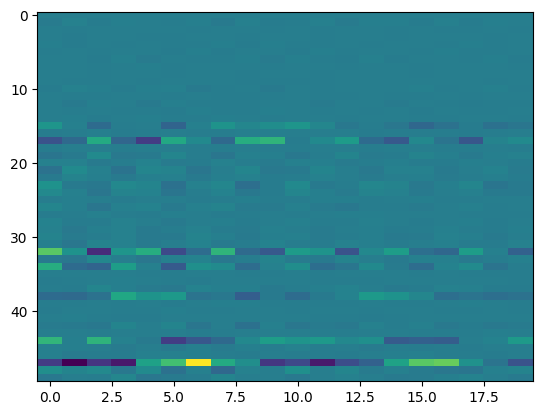

In [230]:
plt.imshow(test_x.squeeze(0).T, aspect='auto')

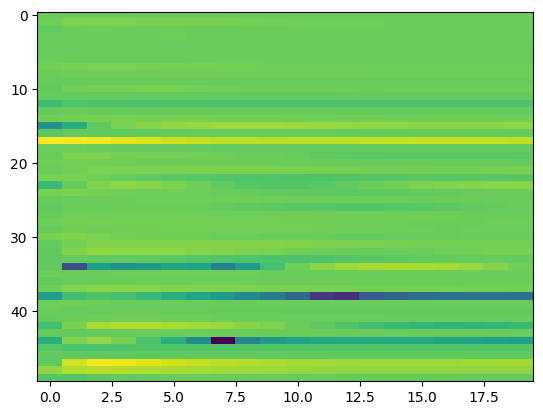

In [231]:
plt.imshow(test_reco.squeeze(0).T.detach().cpu().abs().log(), aspect='auto')

In [232]:
test_x.shape

torch.Size([1, 20, 50])

In [233]:
test_x_wave = torch.zeros([(len(test_x.squeeze(0))+1)*stride])
for i,patch in enumerate(torch.mm(test_x.squeeze(0) *pca_means, v.T)):
    test_x_wave[i*stride:i*stride+patch_size] += patch/2

In [234]:
Audio(test_x_wave, rate=rate)

In [235]:
test_reco_wave = torch.zeros([(len(test_reco.squeeze(0))+1)*stride]).detach().cpu()
for i,patch in enumerate(torch.mm(test_reco.squeeze(0).detach().cpu()*pca_means, v.T)):
    test_reco_wave[i*stride:i*stride+patch_size] += patch/2

In [236]:
Audio(test_reco_wave, rate=rate)

In [280]:
dataset_recos = rae(dataset.to(device))

In [281]:
dataset_recos.shape

torch.Size([801, 20, 50])

In [283]:
dataset_recos = dataset_recos[:,:10,:].reshape([801*10, 50])

In [289]:
dataset_recos = torch.mm(dataset_recos.detach().cpu()*pca_means, v.T)

In [291]:
# reassemble audio from patches
audio_reco = torch.zeros_like(waves)
for i, start in enumerate(starts):
    try:
        audio_reco[start:start+patch_size] += dataset_recos[i]/2
    except IndexError:
        break

In [294]:
Audio(audio_reco[rate:rate*20+rate*20], rate=rate)